# I. CÀI ĐẶT / IMPORT THƯ VIỆN / LOAD DATA


In [117]:
!pip install datasets accelerate evaluate torchvision

In [118]:
import psutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models

from datasets import load_dataset, DatasetDict
from datasets import Features, Value, Image
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [119]:
# Kiểm tra RAM
available_ram = psutil.virtual_memory().available
cpu_count = psutil.cpu_count(logical=True)
print(f"Available RAM: {available_ram / (1024**3):.2f} GB")
print(f"CPU count: {cpu_count}")

Available RAM: 23.95 GB
CPU count: 56


## 1.1 Tải dataset từ Hugging Face

In [120]:
dataset_dict  = load_dataset("ashraq/fashion-product-images-small")
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['id', 'gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName', 'image'],
        num_rows: 44072
    })
})


In [121]:
# Dữ liệu gốc: dataset_dict["train"]
train_dataset_org = dataset_dict["train"]

In [122]:
# Xem thử 1 record
print(train_dataset_org[0])

{'id': 15970, 'gender': 'Men', 'masterCategory': 'Apparel', 'subCategory': 'Topwear', 'articleType': 'Shirts', 'baseColour': 'Navy Blue', 'season': 'Fall', 'year': 2011.0, 'usage': 'Casual', 'productDisplayName': 'Turtle Check Men Navy Blue Shirt', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F12FE320A30>}


# II. TIỀN XỬ LÝ & CHUẨN BỊ DỮ LIỆU

## 2.1 Thêm cột giá (price) minh hoạ

In [123]:
def assign_price(masterCategory, subCategory, articleType, year, season, usage):
    """Giả lập sinh giá tiền dựa trên masterCategory/subCategory/..."""
    import numpy as np
    master_price_range = {
        'Apparel': (10, 20), 'Accessories': (5, 100), 'Footwear': (20, 200),
        'Personal Care': (5, 300), 'Free Items': (0, 5), 'Sporting Goods': (100, 250), 'Home': (100, 300)
    }
    sub_price_adjustment = {
        'Topwear': (5, 50), 'Watches': (30, 150), 'Shoes': (20, 100),
        'Bags': (10, 70), 'Fragrance': (5, 80), 'Jewellery': (10, 200)
    }
    article_price_range = {
        'Shirts': (15, 70), 'Watches': (50, 300), 'Sports Shoes': (40, 200),
        'Sunglasses': (30, 150), 'Perfumes': (25, 120)
    }
    # Lấy khoảng giá từ masterCategory
    base_min, base_max = master_price_range.get(masterCategory, (10, 100))
    # Điều chỉnh theo subCategory
    adj_min, adj_max = sub_price_adjustment.get(subCategory, (0, 0))
    # Điều chỉnh theo articleType
    art_min, art_max = article_price_range.get(articleType, (base_min + adj_min, base_max + adj_max))
    # Điều chỉnh năm
    if year < 2015:
        discount = 0.3
    elif year < 2018:
        discount = 0.15
    else:
        discount = 0
    final_min = art_min * (1 - discount)
    final_max = art_max * (1 - discount)
    return round(np.random.uniform(final_min, final_max) * 2500, 0)

In [124]:
def add_price_column(example):
    example["price_in_vnd"] = assign_price(
        example["masterCategory"],
        example["subCategory"],
        example["articleType"],
        example["year"],
        example["season"],
        example["usage"]
    )
    return example

In [125]:
# Loại bỏ record null
def has_null(example):
    return any(val is None for val in example.values())

missing_null = dataset_dict["train"].filter(has_null)
print(f"Số record có giá trị null: {len(missing_null)}")

Số record có giá trị null: 0


In [126]:
# Mapped dataset
dataset_dict["train"] = dataset_dict["train"].map(add_price_column)

In [127]:
# Tách train/val/test (10% test, 10% val)
train_test_split = dataset_dict['train'].train_test_split(test_size=0.1, seed=42)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1, seed=42)

In [128]:
final_dataset = DatasetDict({
    'train': train_val_split['train'],
    'val': train_val_split['test'],
    'test': train_test_split['test']
})

In [129]:
train_dataset = final_dataset["train"]
val_dataset   = final_dataset["val"]
test_dataset  = final_dataset["test"]

In [130]:
# Định nghĩa features (để cast)
features = Features({
    'id': Value('int64'),
    'gender': Value('string'),
    'masterCategory': Value('string'),
    'subCategory': Value('string'),
    'articleType': Value('string'),
    'baseColour': Value('string'),
    'season': Value('string'),
    'year': Value('int64'),
    'usage': Value('string'),
    'productDisplayName': Value('string'),
    'image': Image(),
    'price_in_vnd': Value('int64')
})

In [131]:
train_dataset = train_dataset.cast(features)
val_dataset   = val_dataset.cast(features)
test_dataset  = test_dataset.cast(features)

## 2.2 Tạo cột brand (chỉ số hoá) từ 'productDisplayName' + 'gender'

In [132]:
def extract_brand(name, gender):
    # Ví dụ: tách brand bằng cách lấy chuỗi trước từ "gender"
    name_lower   = name.lower()
    gender_lower = gender.lower()
    tokens       = name.split(" ")
    tokens_lower = name_lower.split(" ")
    if gender_lower in tokens_lower:
        idx = tokens_lower.index(gender_lower)
        brand_tokens = tokens[:idx]
        brand = " ".join(brand_tokens).replace("by","").strip()
        return brand
    else:
        return tokens[0]


In [133]:
def build_brand_mapping(dataset):
    brands = []
    for name, gender in zip(dataset["productDisplayName"], dataset["gender"]):
        brands.append(extract_brand(name, gender))
    unique_brands = sorted(list(set(brands)))
    mapping = {brand: idx for idx, brand in enumerate(unique_brands)}
    inv_mapping = {idx: brand for brand, idx in mapping.items()}
    return mapping, inv_mapping

In [134]:
def build_mapping(dataset, col):
    unique_labels = dataset.unique(col)
    unique_labels.sort()
    mapping = {label: idx for idx, label in enumerate(unique_labels)}
    inv_mapping = {idx: label for label, idx in mapping.items()}
    return mapping, inv_mapping

In [135]:
# Sinh mapping dựa trên FULL dataset gốc (train_dataset_org) hoặc tuỳ
gender_map, inv_gender_map           = build_mapping(train_dataset_org, "gender")
master_category_map, inv_master_map  = build_mapping(train_dataset_org, "masterCategory")
sub_category_map, inv_sub_cat_map    = build_mapping(train_dataset_org, "subCategory")
article_type_map, inv_article_type_map = build_mapping(train_dataset_org, "articleType")
base_colour_map, inv_base_colour_map = build_mapping(train_dataset_org, "baseColour")
usage_map, inv_usage_map             = build_mapping(train_dataset_org, "usage")
brand_map, inv_brand_map             = build_brand_mapping(train_dataset_org)

In [136]:
import pickle
# Lưu tất cả các ánh xạ vào một dictionary
all_mappings = {
    'inv_brand_map': inv_brand_map,
    'inv_gender_map': inv_gender_map,
    'inv_usage_map': inv_usage_map,
    'inv_base_colour_map': inv_base_colour_map,
    'inv_master_map': inv_master_map,
    'inv_sub_cat_map': inv_sub_cat_map,
    'inv_article_type_map': inv_article_type_map
}

# Lưu tất cả ánh xạ vào một file Pickle
with open("mappings.pkl", "wb") as f:
    pickle.dump(all_mappings, f)

print("Mappings saved successfully!")

Mappings saved successfully!


In [137]:
def update_categorical(example):
    # Thay thế string bằng ID
    example["gender"]         = gender_map[example["gender"]]
    example["masterCategory"] = master_category_map[example["masterCategory"]]
    example["subCategory"]    = sub_category_map[example["subCategory"]]
    example["articleType"]    = article_type_map[example["articleType"]]
    example["baseColour"]     = base_colour_map[example["baseColour"]]
    example["usage"]          = usage_map[example["usage"]]
    # brand
    extracted          = extract_brand(example["productDisplayName"], inv_gender_map[example["gender"]])
    example["brand"]   = brand_map.get(extracted, -1)  # -1 nếu ko match
    return example

In [138]:
train_dataset = train_dataset.map(update_categorical)
val_dataset   = val_dataset.map(update_categorical)
test_dataset  = test_dataset.map(update_categorical)

In [139]:
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

def scale_dataset(ds, scaler):
    arr = np.array([ds[col] for col in ["year","price_in_vnd"]]).T
    scaled = scaler.transform(arr)
    def f(ex, idx):
        return {
            "year": scaled[idx][0],
            "price_in_vnd": scaled[idx][1]
        }
    ds = ds.map(f, with_indices=True)
    return ds

# Fit scaler trên train
arr_train = np.array([train_dataset[col] for col in ["year","price_in_vnd"]]).T
scaled_train = min_max_scaler.fit_transform(arr_train)

In [140]:
def f_train(ex, idx):
    return {
        "year": scaled_train[idx][0],
        "price_in_vnd": scaled_train[idx][1]
    }
train_dataset = train_dataset.map(f_train, with_indices=True)

# Transform val, test
val_dataset  = scale_dataset(val_dataset, min_max_scaler)
test_dataset = scale_dataset(test_dataset, min_max_scaler)

In [141]:
# Encode season thủ công
season_mapping = {'Spring': 0, 'Summer': 1, 'Fall': 2, 'Winter': 3}
train_dataset = train_dataset.map(lambda x: {'season': season_mapping[x['season']]})
val_dataset   = val_dataset.map(lambda x: {'season': season_mapping[x['season']]})
test_dataset  = test_dataset.map(lambda x: {'season': season_mapping[x['season']]})


In [142]:
# Bỏ cột productDisplayName nếu muốn (đỡ cồng kềnh)
train_dataset = train_dataset.remove_columns(["productDisplayName"])
val_dataset   = val_dataset.remove_columns(["productDisplayName"])
test_dataset  = test_dataset.remove_columns(["productDisplayName"])


In [143]:
train_dataset.features

{'id': Value(dtype='int64', id=None),
 'gender': Value(dtype='int64', id=None),
 'masterCategory': Value(dtype='int64', id=None),
 'subCategory': Value(dtype='int64', id=None),
 'articleType': Value(dtype='int64', id=None),
 'baseColour': Value(dtype='int64', id=None),
 'season': Value(dtype='int64', id=None),
 'year': Value(dtype='float64', id=None),
 'usage': Value(dtype='int64', id=None),
 'image': Image(mode=None, decode=True, id=None),
 'price_in_vnd': Value(dtype='float64', id=None),
 'brand': Value(dtype='int64', id=None)}

In [144]:
print("Train sample:", train_dataset[0])

Train sample: {'id': 32762, 'gender': 2, 'masterCategory': 1, 'subCategory': 38, 'articleType': 103, 'baseColour': 2, 'season': 1, 'year': 0.4166666666666572, 'usage': 2, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=60x80 at 0x7F14DBB52710>, 'price_in_vnd': 0.14414646629250383, 'brand': 405}


# III. CHUẨN BỊ DataLoader

In [145]:
import torchvision.transforms as transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),          # Resize về 224x224
    transforms.RandomHorizontalFlip(p=0.5), # Lật ngang ngẫu nhiên 50%
    transforms.ToTensor(),
    transforms.RandomRotation(degrees=15),  # Xoay ±15 độ
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Biến đổi màu sắc
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)), # Crop ngẫu nhiên rồi resize về 224x224
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)), # Dịch chuyển ngẫu nhiên ±10% ảnh
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3)), # Cắt xóa vùng ảnh ngẫu nhiên
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Chuẩn hóa theo ImageNet
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [146]:
class FashionDataset(Dataset):
    """
    Dataset trả về (image_tensor, numeric_tensor, labels_dict)
    """
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        # 1) Ảnh
        image = item["image"].convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 2) Numeric features (season, year, price_in_vnd)
        #    -> float tensor
        #    -> Bạn có thể thêm bớt cột tuỳ ý
        numeric_features = [
            item["season"],       # float
            item["year"],         # float (đã scale)
            item["price_in_vnd"]  # float (đã scale)
        ]
        numeric_features = torch.tensor(numeric_features, dtype=torch.float)

        # 3) Labels (7 đầu ra multi-task)
        labels = {}
        labels["gender"]         = torch.tensor(item["gender"], dtype=torch.long)
        labels["masterCategory"] = torch.tensor(item["masterCategory"], dtype=torch.long)
        labels["usage"]          = torch.tensor(item["usage"], dtype=torch.long)
        labels["subCategory"]    = torch.tensor(item["subCategory"], dtype=torch.long)
        labels["articleType"]    = torch.tensor(item["articleType"], dtype=torch.long)
        labels["baseColour"]     = torch.tensor(item["baseColour"], dtype=torch.long)
        labels["brand"]          = torch.tensor(item["brand"], dtype=torch.long)

        return image, numeric_features, labels

In [147]:
# Tạo Torch Dataset & DataLoader
train_torch_dataset = FashionDataset(train_dataset, transform=train_transform)
val_torch_dataset   = FashionDataset(val_dataset,   transform=val_test_transform)
test_torch_dataset  = FashionDataset(test_dataset,  transform=val_test_transform)

In [148]:
train_loader = DataLoader(train_torch_dataset, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_torch_dataset,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_torch_dataset,  batch_size=32, shuffle=False, num_workers=0)

print("Số batch train:", len(train_loader), "Số batch val:", len(val_loader))

Số batch train: 1116 Số batch val: 124


# IV. XÂY DỰNG CNN + MLP = FUSION MULTI-HEAD

In [149]:
num_gender         = len(gender_map)         # 5
num_master         = len(master_category_map)# 7
num_usage          = len(usage_map)          # 8
num_subcategory    = len(sub_category_map)   # 45
num_article        = len(article_type_map)   # 142
num_basecolour     = len(base_colour_map)    # 46
num_brand          = len(brand_map)          # ~820 (tuỳ dataset)
num_sub = len(sub_category_map)
num_article = len(article_type_map)
num_base = len(base_colour_map)
num_brand = len(brand_map)

# Hoặc in ra cho chắc:
print("num_gender", num_gender)
print("num_master", num_master)
print("num_usage",  num_usage)
print("num_subcategory", num_subcategory)
print("num_article", num_article)
print("num_basecolour", num_basecolour)
print("num_brand", num_brand)

num_gender 5
num_master 7
num_usage 8
num_subcategory 45
num_article 141
num_basecolour 46
num_brand 817


In [150]:
# Định nghĩa TransformerBlock dùng cho Stage 1 và Stage 2
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_hidden):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.ff = nn.Sequential(
            nn.Linear(embed_dim, ff_hidden),
            nn.ReLU(),
            nn.Linear(ff_hidden, embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Self-attention: x shape [B, seq_len, embed_dim]
        attn_output, _ = self.attention(x, x, x)
        x = self.norm1(x + attn_output)
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

In [151]:
# Định nghĩa mô hình EndToEndHierarchicalModel
class EndToEndHierarchicalModel(nn.Module):
    def __init__(
        self,
        num_gender, num_master, num_usage,
        num_sub, num_article, num_base,
        num_brand,
        pretrained=True,
        mlp_hidden=32,
        embed_dim=16,
        teacher_forcing_p=0.5
    ):
        super().__init__()
        self.teacher_forcing_p = teacher_forcing_p

        # 1) Backbone CNN (sử dụng ResNet50)
        self.backbone = models.resnet50(pretrained=pretrained)
        backbone_out = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()

        # 2) MLP xử lý numeric (3 input: [season, year, price])
        self.mlp = nn.Sequential(
            nn.Linear(3, mlp_hidden),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(mlp_hidden, mlp_hidden),
            nn.BatchNorm1d(mlp_hidden),
            nn.ReLU()
        )

        self.base_feat_dim = backbone_out + mlp_hidden

        # ---------- Stage 1 ----------
        self.head_gender = nn.Linear(self.base_feat_dim, num_gender)
        self.head_master = nn.Linear(self.base_feat_dim, num_master)
        self.head_usage  = nn.Linear(self.base_feat_dim, num_usage)

        self.embed_gender = nn.Embedding(num_gender, embed_dim)
        self.embed_master = nn.Embedding(num_master, embed_dim)
        self.embed_usage  = nn.Embedding(num_usage,  embed_dim)

        # Attention và Transformer cho Stage 1
        self.attention_stage1 = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1, batch_first=True)
        self.transformer_block_stage1 = TransformerBlock(embed_dim, num_heads=4, ff_hidden=embed_dim*4)

        # ---------- Stage 2 ----------
        stage1_embed_total = 3 * embed_dim
        stage2_input_dim = self.base_feat_dim + stage1_embed_total

        self.head_sub     = nn.Linear(stage2_input_dim, num_sub)
        self.head_article = nn.Linear(stage2_input_dim, num_article)
        self.head_base    = nn.Linear(stage2_input_dim, num_base)

        self.embed_sub     = nn.Embedding(num_sub,     embed_dim)
        self.embed_article = nn.Embedding(num_article, embed_dim)
        self.embed_base    = nn.Embedding(num_base,    embed_dim)

        # Transformer block cho Stage 2 (áp dụng cho các embedding của subCategory, articleType, baseColour)
        self.attention_stage2 = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=1, batch_first=True)
        self.transformer_block_stage2 = TransformerBlock(embed_dim, num_heads=4, ff_hidden=embed_dim*4)

        # ---------- Stage 3 ----------
        stage2_embed_total = 3 * embed_dim  # Sẽ tính sau khi xử lý stage 2
        stage3_input_dim   = self.base_feat_dim + stage1_embed_total + stage2_embed_total
        self.head_brand = nn.Linear(stage3_input_dim, num_brand)

    def set_teacher_forcing_p(self, p):
        self.teacher_forcing_p = p

    def forward(self, images, numeric_data=None, labels=None):
        batch_size = images.size(0)

        # 1) Trích xuất đặc trưng ảnh qua backbone
        cnn_feat = self.backbone(images)

        # 2) Xử lý numeric data qua MLP
        if numeric_data is None:
            numeric_data = torch.zeros(batch_size, 3, device=images.device)
        mlp_feat = self.mlp(numeric_data)
        base_feat = torch.cat([cnn_feat, mlp_feat], dim=1)  # [B, base_feat_dim]

        # =============== STAGE 1: Dự đoán gender, masterCategory, usage ===============
        out_gender = self.head_gender(base_feat)
        out_master = self.head_master(base_feat)
        out_usage  = self.head_usage(base_feat)

        pred_gender_id = torch.argmax(out_gender, dim=1)
        pred_master_id = torch.argmax(out_master, dim=1)
        pred_usage_id  = torch.argmax(out_usage, dim=1)

        if (labels is not None) and self.training:
            gt_gender_id = labels["gender"]
            gt_master_id = labels["masterCategory"]
            gt_usage_id  = labels["usage"]

            tf_mask = torch.rand(batch_size, device=images.device) < self.teacher_forcing_p

            used_gender_id = torch.where(tf_mask, gt_gender_id, pred_gender_id)
            used_master_id = torch.where(tf_mask, gt_master_id, pred_master_id)
            used_usage_id  = torch.where(tf_mask, gt_usage_id, pred_usage_id)
        else:
            used_gender_id = pred_gender_id
            used_master_id = pred_master_id
            used_usage_id  = pred_usage_id

        # Lấy embedding cho từng nhãn và thêm chiều sequence (1 token mỗi nhãn)
        embed_g = self.embed_gender(used_gender_id).unsqueeze(1)  # [B, 1, embed_dim]
        embed_m = self.embed_master(used_master_id).unsqueeze(1)    # [B, 1, embed_dim]
        embed_u = self.embed_usage(used_usage_id).unsqueeze(1)      # [B, 1, embed_dim]

        # Tạo stage1_tokens: ghép các embedding thành tensor [B, 3, embed_dim]
        stage1_tokens = torch.cat([embed_g, embed_m, embed_u], dim=1)

        # Áp dụng attention cơ bản cho stage 1:
        attended_stage1, _ = self.attention_stage1(stage1_tokens, stage1_tokens, stage1_tokens)
        # Áp dụng Transformer Block cho stage 1:
        attended_stage1 = self.transformer_block_stage1(attended_stage1)
        # Flatten thành vector duy nhất: [B, 3*embed_dim]
        stage1_embed = attended_stage1.view(batch_size, -1)

        # =============== STAGE 2: Dự đoán subCategory, articleType, baseColour ===============
        # Tạo dự đoán ban đầu cho Stage 2
        out_sub     = self.head_sub(torch.cat([base_feat, stage1_embed], dim=1))
        out_article = self.head_article(torch.cat([base_feat, stage1_embed], dim=1))
        out_base    = self.head_base(torch.cat([base_feat, stage1_embed], dim=1))

        pred_sub_id     = torch.argmax(out_sub, dim=1)
        pred_article_id = torch.argmax(out_article, dim=1)
        pred_base_id    = torch.argmax(out_base, dim=1)

        if (labels is not None) and self.training:
            gt_sub_id     = labels["subCategory"]
            gt_article_id = labels["articleType"]
            gt_base_id    = labels["baseColour"]

            tf_mask2 = torch.rand(batch_size, device=images.device) < self.teacher_forcing_p

            used_sub_id     = torch.where(tf_mask2, gt_sub_id, pred_sub_id)
            used_article_id = torch.where(tf_mask2, gt_article_id, pred_article_id)
            used_base_id    = torch.where(tf_mask2, gt_base_id, pred_base_id)
        else:
            used_sub_id     = pred_sub_id
            used_article_id = pred_article_id
            used_base_id    = pred_base_id

        # Lấy embedding cho các nhãn ở Stage 2:
        embed_s = self.embed_sub(used_sub_id)
        embed_a = self.embed_article(used_article_id)
        embed_b = self.embed_base(used_base_id)

        # Tạo stage2_tokens với shape [B, 3, embed_dim] thay vì chỉ concat:
        stage2_tokens = torch.stack([embed_s, embed_a, embed_b], dim=1)
        # Áp dụng attention cơ bản cho stage 1:
        attended_stage2, _ = self.attention_stage2(stage2_tokens, stage2_tokens, stage2_tokens)
        # Áp dụng Transformer Block cho Stage 2:
        attended_stage2 = self.transformer_block_stage2(stage2_tokens)
        # Flatten lại thành vector: [B, 3*embed_dim]
        stage2_embed = attended_stage2.view(batch_size, -1)

        # =============== STAGE 3: Dự đoán brand ===============
        # Ghép base_feat, stage1_embed, và stage2_embed lại để tạo đầu vào cho Stage 3:
        stage3_input = torch.cat([base_feat, stage1_embed, stage2_embed], dim=1)
        out_brand = self.head_brand(stage3_input)

        outputs = {
            "gender": out_gender,
            "masterCategory": out_master,
            "usage": out_usage,
            "subCategory": out_sub,
            "articleType": out_article,
            "baseColour": out_base,
            "brand": out_brand
        }
        return outputs

In [152]:
def hierarchical_loss(outputs, labels):
    """
    Tính loss = trung bình loss 3 stage.
    Stage 1: (gender, masterCategory, usage)
    Stage 2: (subCategory, articleType, baseColour)
    Stage 3: (brand)
    """
    # Stage 1
    loss_s1 = (
        F.cross_entropy(outputs["gender"],         labels["gender"]) +
        F.cross_entropy(outputs["masterCategory"], labels["masterCategory"]) +
        F.cross_entropy(outputs["usage"],          labels["usage"])
    ) / 3.0

    # Stage 2
    loss_s2 = (
        F.cross_entropy(outputs["subCategory"],    labels["subCategory"]) +
        F.cross_entropy(outputs["articleType"],    labels["articleType"]) +
        F.cross_entropy(outputs["baseColour"],     labels["baseColour"])
    ) / 3.0

    # Stage 3
    loss_s3 = F.cross_entropy(outputs["brand"], labels["brand"])

    # Trung bình stage 1,2,3
    loss_total = (loss_s1 + loss_s2 + loss_s3) / 3.0
    return loss_total


In [153]:
# Khởi tạo model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [154]:
model = EndToEndHierarchicalModel(
    num_gender, num_master, num_usage,
    num_sub, num_article, num_base,
    num_brand,
    pretrained=True,
    mlp_hidden=32,
    embed_dim=16,
    teacher_forcing_p=0.5
).to(device)

/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ailab1/miniconda3/envs/thanh-env/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# V. TRAINING LOOP

In [155]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [156]:
def multi_task_loss(outputs, labels):
    total_loss = 0
    for key in labels:
        total_loss += F.cross_entropy(outputs[key], labels[key])
    return total_loss

In [157]:
def train_one_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for images, numeric_data, labels_dict in dataloader:
        images = images.to(device)
        numeric_data = numeric_data.to(device)
        for k in labels_dict:
            labels_dict[k] = labels_dict[k].to(device)

        optimizer.zero_grad()
        outputs = model(images, numeric_data, labels=labels_dict)
        loss = hierarchical_loss(outputs, labels_dict)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [158]:
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0
    correct_counts = {k: 0 for k in ["gender","masterCategory","usage","subCategory","articleType","baseColour","brand"]}
    total_samples  = 0

    with torch.no_grad():
        for images, numeric_data, labels_dict in dataloader:
            images = images.to(device)
            numeric_data = numeric_data.to(device)
            for k in labels_dict:
                labels_dict[k] = labels_dict[k].to(device)

            outputs = model(images, numeric_data, labels=labels_dict)
            loss = hierarchical_loss(outputs, labels_dict)
            total_loss += loss.item()

            batch_size = images.size(0)
            total_samples += batch_size
            for k in labels_dict:
                preds = torch.argmax(outputs[k], dim=1)
                correct_counts[k] += (preds == labels_dict[k]).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracies = {}
    for k in correct_counts:
        accuracies[k] = correct_counts[k] / float(total_samples)
    return avg_loss, accuracies

In [ ]:
num_epochs = 10
teacher_forcing_decay = 0.8  # Mỗi epoch giảm 10%
train_losses = []
val_losses = []
for epoch in range(num_epochs):
    # Cập nhật teacher forcing
    new_tf_p = model.teacher_forcing_p * teacher_forcing_decay
    model.set_teacher_forcing_p(new_tf_p)

    train_loss = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_accs = evaluate(model, val_loader)
    scheduler.step()

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - teacher_forcing_p: {model.teacher_forcing_p:.4f}")
    print(f"Epoch [{epoch+1}/{num_epochs}]")
    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val   Loss: {val_loss:.4f}")
    for task, acc in val_accs.items():
        print(f"       Val {task} Acc: {acc*100:.2f}%")

Epoch [1/10] - teacher_forcing_p: 0.4000
Epoch [1/10]
   Train Loss: 1.7069
   Val   Loss: 1.3080
       Val gender Acc: 87.24%
       Val masterCategory Acc: 98.87%
       Val usage Acc: 90.35%
       Val subCategory Acc: 91.56%
       Val articleType Acc: 78.65%
       Val baseColour Acc: 56.37%
       Val brand Acc: 29.77%
Epoch [2/10] - teacher_forcing_p: 0.3200
Epoch [2/10]
   Train Loss: 1.2390
   Val   Loss: 1.1589
       Val gender Acc: 86.72%
       Val masterCategory Acc: 99.02%
       Val usage Acc: 91.00%
       Val subCategory Acc: 93.65%
       Val articleType Acc: 82.20%
       Val baseColour Acc: 59.49%
       Val brand Acc: 35.92%
Epoch [3/10] - teacher_forcing_p: 0.2560
Epoch [3/10]
   Train Loss: 1.0790
   Val   Loss: 1.0614
       Val gender Acc: 89.29%
       Val masterCategory Acc: 98.92%
       Val usage Acc: 91.23%
       Val subCategory Acc: 95.01%
       Val articleType Acc: 84.37%
       Val baseColour Acc: 60.83%
       Val brand Acc: 40.64%
Epoch [4/10] - t

In [ ]:
import matplotlib.pyplot as plt

# Giả sử bạn có 2 list chứa giá trị loss của train và validation sau mỗi epoch:
# train_losses = [loss_epoch1, loss_epoch2, ..., loss_epochN]
# val_losses   = [val_loss_epoch1, val_loss_epoch2, ..., val_loss_epochN]
# Và số epoch:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

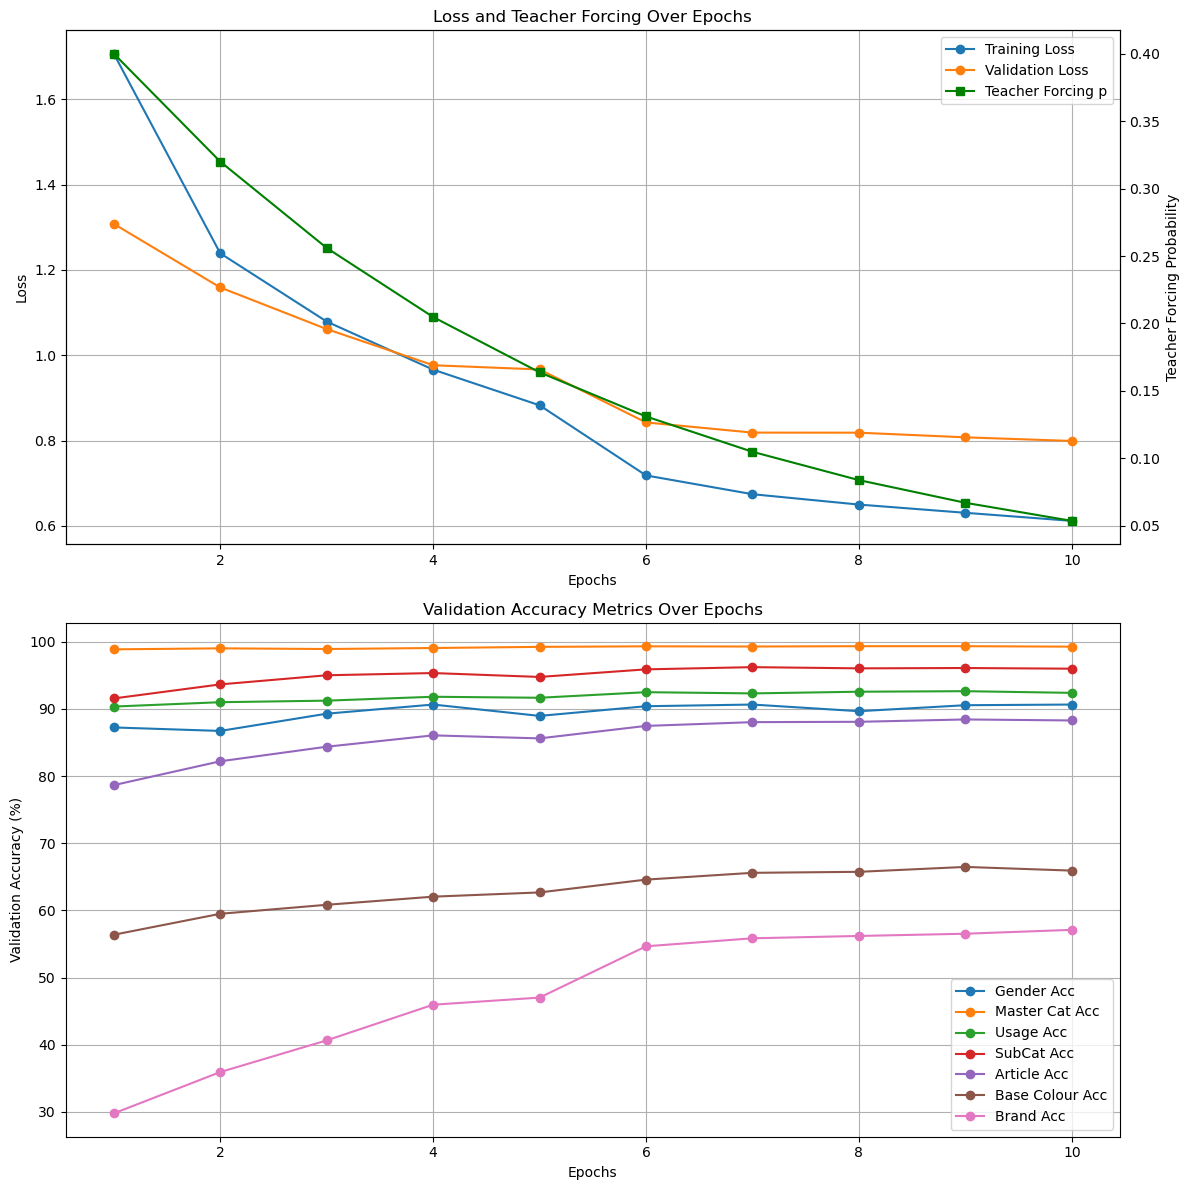

In [169]:
import matplotlib.pyplot as plt

# Epochs (1 to 10)
epochs = list(range(1, 11))

# Loss values from your logs:
train_losses = [1.7069, 1.2390, 1.0790, 0.9663, 0.8827, 0.7183, 0.6743, 0.6500, 0.6307, 0.6118]
val_losses   = [1.3080, 1.1589, 1.0614, 0.9766, 0.9667, 0.8425, 0.8187, 0.8185, 0.8076, 0.7991]
teacher_forcing = [0.4000, 0.3200, 0.2560, 0.2048, 0.1638, 0.1311, 0.1049, 0.0839, 0.0671, 0.0537]

# Validation Accuracy values (in percentages):
acc_gender   = [87.24, 86.72, 89.29, 90.65, 88.96, 90.40, 90.65, 89.66, 90.55, 90.65]
acc_master   = [98.87, 99.02, 98.92, 99.07, 99.24, 99.32, 99.29, 99.34, 99.34, 99.27]
acc_usage    = [90.35, 91.00, 91.23, 91.81, 91.66, 92.49, 92.31, 92.56, 92.64, 92.39]
acc_sub      = [91.56, 93.65, 95.01, 95.34, 94.76, 95.89, 96.22, 96.04, 96.09, 95.99]
acc_article  = [78.65, 82.20, 84.37, 86.06, 85.61, 87.47, 88.03, 88.08, 88.43, 88.28]
acc_base     = [56.37, 59.49, 60.83, 62.04, 62.67, 64.58, 65.59, 65.74, 66.47, 65.92]
acc_brand    = [29.77, 35.92, 40.64, 45.95, 47.01, 54.65, 55.84, 56.19, 56.52, 57.10]

# Create one figure with 2 subplots (stacked vertically)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

# ---- Top subplot: Losses and Teacher Forcing ----
ln1 = ax1.plot(epochs, train_losses, label='Training Loss', marker='o')
ln2 = ax1.plot(epochs, val_losses, label='Validation Loss', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Loss and Teacher Forcing Over Epochs')
ax1.grid(True)

# Add teacher forcing probability on a twin y-axis (since its scale is different)
ax1_twin = ax1.twinx()
ln3 = ax1_twin.plot(epochs, teacher_forcing, label='Teacher Forcing p', marker='s', color='green')
ax1_twin.set_ylabel('Teacher Forcing Probability')

# Combine legends from both y-axes
lns = ln1 + ln2 + ln3
labels = [l.get_label() for l in lns]
ax1.legend(lns, labels, loc='upper right')

# ---- Bottom subplot: Validation Accuracy Metrics ----
ax2.plot(epochs, acc_gender,    label='Gender Acc', marker='o')
ax2.plot(epochs, acc_master,    label='Master Cat Acc', marker='o')
ax2.plot(epochs, acc_usage,     label='Usage Acc', marker='o')
ax2.plot(epochs, acc_sub,       label='SubCat Acc', marker='o')
ax2.plot(epochs, acc_article,   label='Article Acc', marker='o')
ax2.plot(epochs, acc_base,      label='Base Colour Acc', marker='o')
ax2.plot(epochs, acc_brand,     label='Brand Acc', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Validation Accuracy (%)')
ax2.set_title('Validation Accuracy Metrics Over Epochs')
ax2.grid(True)
ax2.legend(loc='lower right')

plt.tight_layout()
plt.show()


# VI. ĐÁNH GIÁ TRÊN TEST

In [160]:
test_loss, test_accs = evaluate(model, test_loader)
print(f"[Test] Loss: {test_loss:.4f}")
for task, acc in test_accs.items():
    print(f"[Test] {task} Accuracy = {acc*100:.2f}%")

[Test] Loss: 0.7796
[Test] gender Accuracy = 90.79%
[Test] masterCategory Accuracy = 99.57%
[Test] usage Accuracy = 92.35%
[Test] subCategory Accuracy = 96.28%
[Test] articleType Accuracy = 87.23%
[Test] baseColour Accuracy = 66.18%
[Test] brand Accuracy = 58.64%


In [161]:
transform_infer = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [162]:
from PIL import Image

def predict_product_display_name(
    model,
    image_path,
    numeric_data=None  # tuple/list [season, year, price] hoặc None
):
    """
    - image_path: đường dẫn ảnh
    - numeric_data: [season, year, price] hoặc None
    - return: predicted_display_name (chuỗi)
    """

    # 1) Load & transform ảnh
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform_infer(img).unsqueeze(0)  # [1,3,224,224]

    # 2) numeric_data
    if numeric_data is not None:
        numeric_data = torch.tensor(numeric_data, dtype=torch.float).unsqueeze(0)
        # shape [1,3]
    else:
        numeric_data = None

    # 3) Model forward
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor.to(device), numeric_data=numeric_data.to(device) if numeric_data is not None else None)

    # 4) Lấy argmax cho mỗi task
    pred_brand_id  = torch.argmax(outputs["brand"], dim=1).item()
    pred_gender_id = torch.argmax(outputs["gender"], dim=1).item()
    pred_usage_id  = torch.argmax(outputs["usage"],  dim=1).item()
    pred_base_id   = torch.argmax(outputs["baseColour"], dim=1).item()
    pred_masterCategory_id = torch.argmax(outputs["masterCategory"], dim=1).item()
    pred_subCategory_id    = torch.argmax(outputs["subCategory"], dim=1).item()
    pred_article_id = torch.argmax(outputs["articleType"], dim=1).item()

    # 5) Chuyển sang chuỗi
    pred_brand_str  = inv_brand_map[pred_brand_id]
    pred_gender_str = inv_gender_map[pred_gender_id]
    pred_usage_str  = inv_usage_map[pred_usage_id]
    pred_base_str   = inv_base_colour_map[pred_base_id]
    pred_masterCategory_str = inv_master_map[pred_masterCategory_id]
    pred_subCategory_str = inv_sub_cat_map[pred_subCategory_id]
    pred_article_str = inv_article_type_map[pred_article_id]

    # 6) Ghép "product display name"
    predicted_display_name = f"{pred_brand_str} {pred_gender_str} {pred_usage_str} {pred_base_str} {pred_article_str}"
    return pred_brand_str, pred_gender_str, pred_usage_str, pred_base_str, pred_masterCategory_str, pred_subCategory_str, pred_article_str, predicted_display_name

In [ ]:
#Trường hợp 1: Người dùng có year/season/price:
# year=2012, season=1, price=0.6 (vd scale 0..1)
numeric_data = [2, 2011, 0.6]
pred_brand_str, pred_gender_str, pred_usage_str, pred_base_str, pred_article_str, predicted_display_name = predict_product_display_name(model, "/home/ailab1/student_share/Thanh/GPU/Data/data test/images/10000.jpg", numeric_data=numeric_data)
print("Predicted:", predicted_display_name)
print("Predicted:", pred_brand_str)


In [165]:
# Trường hợp 2: Người dùng chỉ up ảnh => numeric_data=None
product_name = predict_product_display_name(model, "/home/ailab1/student_share/Thanh/GPU/Data/data test/images/10999.jpg", numeric_data=None)
print("Predicted:", product_name)


Predicted: ('Puma', 'Unisex', 'Sports', 'Black', 'Accessories', 'Watches', 'Watches', 'Puma Unisex Sports Black Watches')


# VII. LƯU MODEL

In [166]:
torch.save(model.state_dict(), "/home/ailab1/student_share/Thanh/GPU/CNN_hierarchical_model.pt")
print("Model weights saved to cnn_plus_mlp_multitask_model.pt")

Model weights saved to cnn_plus_mlp_multitask_model.pt
